In [1]:
import Pkg
Pkg.activate(".")

  Activating project at `~/Documents/BinaryRobustOptimization/BinaryRobustOptimization`


In [37]:
using Revise
using BinaryRobustOptimization
set_num_threads(1)
set_solver_Gurobi()

In [22]:
# problem = UnitCommitment("6bus_JEAS", 1, 1)
# problem = UnitCommitment("118_syst_JEAS", 1, 35)
problem = UnitCommitment("medium", 1, 5)

UnitCommitment("IEEE54", 24, 35, 19, BinaryRobustOptimization.ThermalUnit[BinaryRobustOptimization.ThermalUnit(1, 65, 100.0, 420.0, 210.0, 210.0, 0.0, 250.0, 0.0, 8.3391, 64.16, 260.0, 10, 10, 10), BinaryRobustOptimization.ThermalUnit(2, 66, 100.0, 420.0, 210.0, 210.0, 0.0, 250.0, 0.0, 8.3391, 64.16, 260.0, 10, 10, 10), BinaryRobustOptimization.ThermalUnit(3, 10, 150.0, 300.0, 150.0, 150.0, 0.0, 440.0, 0.0, 12.8875, 6.78, 225.0, 8, 8, 8), BinaryRobustOptimization.ThermalUnit(4, 12, 100.0, 300.0, 150.0, 150.0, 0.0, 110.0, 0.0, 12.8875, 6.78, 200.0, 8, 8, 8), BinaryRobustOptimization.ThermalUnit(5, 25, 100.0, 300.0, 150.0, 150.0, 0.0, 100.0, 0.0, 12.8875, 6.78, 200.0, 8, 8, 8), BinaryRobustOptimization.ThermalUnit(6, 26, 100.0, 350.0, 175.0, 175.0, 0.0, 100.0, 0.0, 10.76, 32.96, 225.0, 8, 8, 8), BinaryRobustOptimization.ThermalUnit(7, 49, 50.0, 250.0, 125.0, 125.0, 0.0, 100.0, 0.0, 12.3299, 28.0, 150.0, 8, 8, 8), BinaryRobustOptimization.ThermalUnit(8, 54, 50.0, 250.0, 125.0, 125.0, 0.0,

In [40]:
function run_unit_commitment(budget_list::Vector{Int}, size_list, method_list, end_time)
    for budget in budget_list
        for size in size_list
            for method in method_list
                println("Budget ", budget, " Size ", size, " Method ", method)
                if size == 1
                    problem = UnitCommitment("6bus_JEAS", budget, 1)
                    run_ccg(problem, method, end_time)
                elseif size == 2
                    problem = UnitCommitment("medium", budget, 5)
                    run_ccg(problem, method, end_time)
                elseif size == 3
                    problem = UnitCommitment("118_syst_JEAS", budget, 35)
                    run_ccg(problem, method, end_time)
                end
            end
        end
    end
end
run_unit_commitment([1], [1, 2, 3], [CCGL, CCGM], 5.0)

run_unit_commitment (generic function with 1 method)

In [ ]:
using Distributed

# Ensure package availability on workers
@everywhere using BinaryRobustOptimization

@everywhere function unit_commitment_job(budget, size, method, end_time)
    println("Budget ", budget, " Size ", size, " Method ", method)
    if size == 1
        problem = UnitCommitment("6bus_JEAS", budget, 1)
    elseif size == 2
        problem = UnitCommitment("medium", budget, 5)
    elseif size == 3
        problem = UnitCommitment("118_syst_JEAS", budget, 35)
    else
        error("Unknown size value: $(size)")
    end
    run_ccg(problem, method, end_time)
end

function run_unit_commitment_parallel(budget_list::Vector{Int}, size_list, method_list, end_time; nworkers = Sys.CPU_THREADS)
    # Ensure enough workers (including master process)
    current = nprocs()
    target = max(2, nworkers)  # at least 2 procs (1 master + 1 worker)
    to_add = max(0, target - current)
    if to_add > 0
        addprocs(to_add)
        @everywhere using BinaryRobustOptimization
        @everywhere set_solver_Gurobi()
    end

    combos = [(b, s, m) for b in budget_list for s in size_list for m in method_list]

    results = pmap(combos) do (b, s, m)
        unit_commitment_job(b, s, m, end_time)
    end

    return results
end

In [ ]:
res_parallel = run_unit_commitment_parallel([1], [1, 2, 3], [CCGL, CCGM], 5.0; nworkers = min(Sys.CPU_THREADS, 4))

In [41]:
run_unit_commitment([1], [1, 2, 3], [CCGL, CCGM], 5.0)

Budget 1 Size 1 Method CCGL


┌ Warning: could not solve master problem to optimality. status = TIME_LIMIT
└ @ BinaryRobustOptimization /home/mathis/Documents/BinaryRobustOptimization/BinaryRobustOptimization/src/utilities.jl:80


Budget 1 Size 1 Method CCGM


┌ Warning: could not solve master problem to optimality. status = TIME_LIMIT
└ @ BinaryRobustOptimization /home/mathis/Documents/BinaryRobustOptimization/BinaryRobustOptimization/src/utilities.jl:80


Budget 1 Size 2 Method CCGL


┌ Warning: could not solve subproblem to optimality. status = TIME_LIMIT
└ @ BinaryRobustOptimization /home/mathis/Documents/BinaryRobustOptimization/BinaryRobustOptimization/src/utilities.jl:104


Budget 1 Size 2 Method CCGM


┌ Warning: could not solve master problem to optimality. status = TIME_LIMIT
└ @ BinaryRobustOptimization /home/mathis/Documents/BinaryRobustOptimization/BinaryRobustOptimization/src/utilities.jl:80


Budget 1 Size 3 Method CCGL


┌ Warning: could not solve subproblem to optimality. status = TIME_LIMIT
└ @ BinaryRobustOptimization /home/mathis/Documents/BinaryRobustOptimization/BinaryRobustOptimization/src/utilities.jl:104


Budget 1 Size 3 Method CCGM


┌ Warning: could not solve master problem to optimality. status = TIME_LIMIT
└ @ BinaryRobustOptimization /home/mathis/Documents/BinaryRobustOptimization/BinaryRobustOptimization/src/utilities.jl:80


In [5]:
budget = 3
scale = 2
problem = Rostering(budget, scale, scale,5)

Rostering("5_42", 24, 6, 42, 8, [15.0 15.0 … 13.0 14.0; 15.0 12.0 … 5.0 11.0; … ; 11.0 5.0 … 5.0 11.0; 12.0 7.0 … 7.0 9.0], [23.0 30.0 … 27.0 21.0; 21.0 20.0 … 25.0 28.0; … ; 22.0 20.0 … 25.0 30.0; 20.0 22.0 … 21.0 27.0], [8.0 8.0 … 6.0 6.0; 4.0 5.0 … 7.0 5.0; … ; 8.0 7.0 … 5.0 8.0; 7.0 5.0 … 7.0 4.0], [8, 10, 16, 16, 10, 10, 14, 8, 14, 8  …  8, 10, 10, 10, 8, 16, 12, 16, 14, 8], [16, 18, 18, 20, 22, 18, 26, 26, 24, 18  …  26, 26, 26, 20, 24, 28, 22, 28, 24, 20], [8, 4, 8, 4, 4, 8], [8, 12, 12, 8, 8, 8], [48.0, 43.0, 50.0, 40.0, 46.0, 46.0, 40.0, 43.0, 40.0, 44.0  …  50.0, 42.0, 50.0, 47.0, 47.0, 43.0, 44.0, 41.0, 41.0, 48.0], [80.0, 94.0, 98.0, 76.0, 156.0, 96.0, 148.0, 100.0, 74.0, 134.0  …  70.0, 112.0, 118.0, 90.0, 138.0, 134.0, 148.0, 118.0, 126.0, 84.0], [4.0, 4.7, 4.9, 3.8000000000000003, 7.800000000000001, 4.800000000000001, 7.4, 5.0, 3.7, 6.7  …  3.5, 5.6000000000000005, 5.9, 4.5, 6.9, 6.7, 7.4, 5.9, 6.300000000000001, 4.2], 3, Vector{JuMP.VariableRef}[], Vector{JuMP.VariableR

In [ ]:
solve_deterministic_problem(problem)

In [23]:
res_ccg_L = run_ccg(problem, CCGL, 60.0)

	inner-iter 1: LB = 3.33595288e7 UB = 3.933875864e7 gap = 15.2% time=0.2sec
	inner-iter 2: LB = 3.34565488e7 UB = 3.34565488e7 gap = 0.0% time=1.7sec
iter 1: LB = 27394.38 UB = 3.34565488e7 gap = 99.92% time=1.7sec
	inner-iter 1: LB = 1.56983394e6 UB = 3.933875864e7 gap = 96.01% time=5.59sec
	inner-iter 2: LB = 1.64799146e6 UB = 1.68186639e6 gap = 2.01% time=7.1sec
	inner-iter 3: LB = 1.64799146e6 UB = 1.67798559e6 gap = 1.79% time=9.78sec
	inner-iter 4: LB = 1.64799146e6 UB = 1.67498761e6 gap = 1.61% time=14.26sec
	inner-iter 5: LB = 1.64799146e6 UB = 1.67410479e6 gap = 1.56% time=20.04sec
	inner-iter 6: LB = 1.64799146e6 UB = 1.67313459e6 gap = 1.5% time=27.33sec
	inner-iter 7: LB = 1.64799146e6 UB = 1.67313459e6 gap = 1.5% time=35.96sec
	inner-iter 8: LB = 1.64799146e6 UB = 1.67313459e6 gap = 1.5% time=46.52sec
	inner-iter 9: LB = 1.64799146e6 UB = 1.67313459e6 gap = 1.5% time=58.3sec


┌ Warning: could not solve master problem to optimality. status = TIME_LIMIT
└ @ BinaryRobustOptimization /home/mathis/Documents/BinaryRobustOptimization/BinaryRobustOptimization/src/utilities.jl:80


("IEEE54_CCGL_62", 24, 1, 62.0, 1.5749686e6, 0.95, [[0.0003788471221923828, 1.306623935699463], [0.00030803680419921875, 0.8778469562530518, 2.0501580238342285, 3.654330015182495, 4.6425111293792725, 6.448312044143677, 7.811186075210571, 9.550432920455933, 10.829766035079956, 3.361417055130005]])

In [24]:
res_ccg_big_M = run_ccg(problem, CCGM, 60.0)

	inner-iter 1: LB = 3.33595288e7 UB = 3.933875864e7 gap = 15.2% time=0.27sec λ = 122503.91950998432
	inner-iter 2: LB = 3.34507276e7 UB = 3.348203272e7 gap = 0.09% time=2.29sec λ = 122503.91950998432
iter 1: LB = 27394.38 UB = 3.348203272e7 gap = 99.92% time=2.29sec λ = 122503.91950998432
	inner-iter 1: LB = 1.66058447e6 UB = 3.933875864e7 gap = 95.78% time=5.01sec λ = 122503.91950998432
	inner-iter 2: LB = 1.69918052e6 UB = 1.75707129e6 gap = 3.29% time=6.01sec λ = 122503.91950998432
	inner-iter 3: LB = 1.72659834e6 UB = 1.75707129e6 gap = 1.73% time=8.35sec λ = 122503.91950998432
	inner-iter 4: LB = 1.72659834e6 UB = 1.74856929e6 gap = 1.26% time=14.73sec λ = 122503.91950998432
	inner-iter 5: LB = 1.72659834e6 UB = 1.74856929e6 gap = 1.26% time=20.75sec λ = 122503.91950998432
	inner-iter 6: LB = 1.72659834e6 UB = 1.74856929e6 gap = 1.26% time=29.11sec λ = 122503.91950998432
	inner-iter 7: LB = 1.72659834e6 UB = 1.74856929e6 gap = 1.26% time=40.42sec λ = 122503.91950998432
	inner-iter

┌ Warning: could not solve master problem to optimality. status = TIME_LIMIT
└ @ BinaryRobustOptimization /home/mathis/Documents/BinaryRobustOptimization/BinaryRobustOptimization/src/utilities.jl:80


("IEEE54_CCGM_66", 24, 1, 66.0, 1.56883611e6, 0.95, [[0.00026702880859375, 1.5258080959320068], [0.0002651214599609375, 0.7506899833679199, 1.7376470565795898, 6.1321001052856445, 5.721795082092285, 8.08276891708374, 11.035867929458618, 13.384078979492188, 11.16920804977417]])

In [96]:
sum([res_ccg_big_M[7][i][k] for i in 1:2 for k in 1:length(res_ccg_big_M[7][i])]), sum([res_ccg_L[7][i][k] for i in 1:2 for k in 1:length(res_ccg_L[7][i])])

(51.8545138835907, 45.88183546066284)

In [ ]:
problem = Rostering(2, 2, 2,4)

In [ ]:
# run_ccg(problem, LinearizedDual, 20.0)
res_ccg_big_M = run_ccg(problem, CCGM, 600.0)

In [ ]:
res_ccg_l = run_ccg(problem, CCGL, 600.0)

In [ ]:
string(round.(res_ccg_l[end], digits=2))

In [ ]:
sum(res_ccg_big_M[end-1])

In [ ]:
sum(res_ccg_l[end-1])

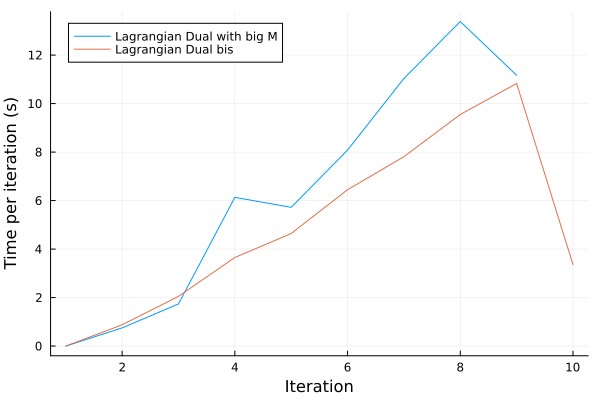

In [25]:
time_ccg_big_M = res_ccg_big_M[7][2]
time_ccg_l = res_ccg_L[7][2]

using Plots
plot(time_ccg_big_M, label="Lagrangian Dual with big M", xlabel="Iteration", ylabel="Time per iteration (s)")
plot!(time_ccg_l, label="Lagrangian Dual bis")

In [ ]:
run_ccg(problem, CCGL, 20.0)

In [ ]:
A=Vector{Float64}[]
push!(A, [1.0,2.0,3.0])
push!(A, [1.0,2.0,3.0])

In [ ]:
minimum([1,2,3])

In [ ]:
run_ccg(problem, CCGM, 20.0)

In [ ]:
iter = 0

while iter < 3
    iter += 1
    sleep(0.2)
    println(iter)
end